In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)

In [2]:
data = pd.read_csv("../data/4_identifying_fraudulent_activity/Fraud_Data.csv")
print(data.shape)
data.head()

(151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
ip_addresses = pd.read_csv("../data/4_identifying_fraudulent_activity/IpAddress_to_Country.csv")
print(ip_addresses.shape)
ip_addresses.head()

(138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
#Let's add the country to the original data set by using the ip address
data_country = [None] * data.shape[0]
  
for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                      (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])
                     ]['country'].values
    if (len(tmp) == 1):  
           data_country[i] = tmp
  
data['country'] = data_country
data['country'] = data['country'].str.get(0)
  
print(data.groupby('country').size().nlargest(10))

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64


In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)
  
#make them dates
data["signup_time"]   = pd.to_datetime(data["signup_time"])
data["purchase_time"] = pd.to_datetime(data["purchase_time"])
#and take the difference
data['purchase_signup_diff'] =  (data["purchase_time"]-data["signup_time"]).dt.total_seconds()
  
#check how for each device id, how many different users had it
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
  
#check how for each ip address, how many different users had it
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')
  
#data set for the model. Drop first 3 vars and device id.
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'],axis=1)
  
#replace None in the country var with "Not_found"
data_rf['country'].replace([None], "Not_found", inplace=True)
  
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)
  
#make dummy
data_rf = pd.get_dummies(data_rf, drop_first=True) 
  
#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)
  
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])
  
#let's print OOB accuracy and confusion matrix
print(
"OOB accuracy is", 
rf.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.9563033298908085 
 OOB Confusion Matrix 
        0     1
0  90351    94
1   4264  5024


In [7]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rf.score(test.drop('class', axis=1),test['class']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)), labels=[0, 1]))
)

Test accuracy is 0.9556238930302263 
 Test Set Confusion Matrix 
        0     1
0  46481    35
1   2245  2618


In [8]:
#We can double check that with a 0.5 cut-off we get the same results shown by rf output(since random forest internally uses 0.5)
#Predictions as probabilities
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
#Predictions as actual classes
pred = rf.predict(test.drop('class', axis=1))
  
#Use 0.5 cutoff for probabilities. I.e. if larger > 0.5, predict 1, else predict 0. A short cut for this is using round function, which does exactly the same. If > 0.5, rounds to 1, else rounds to 0. Check if they are the same:
print(np.array_equal(pred_prob.round(), pred))

True


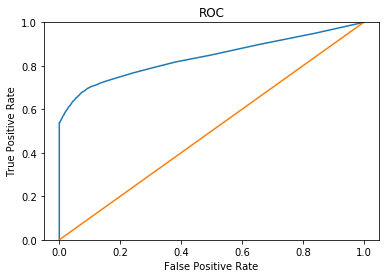

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [10]:

#For consistency with R, we will focus on class errors, defined as class0_error = fpr and class1_error = 1 - tpr
error_cutoff=pd.DataFrame({'cutoff':pd.Series(thresholds),
                               'class0_error':pd.Series(fpr),
                               'class1_error': 1 - pd.Series(tpr)
                                })
error_cutoff['optimal_value'] = 1 - error_cutoff['class1_error'] - error_cutoff['class0_error']
print(error_cutoff.sort_values('optimal_value', ascending=False).head(1))

    cutoff  class0_error  class1_error  optimal_value
58    0.14       0.07333      0.322435       0.604236


You now have a model that assigns to each user a probability of committing a fraud. And, despite our model doing pretty well, no model is perfect. So you will have some misclassifications. It is crucial now to think about building a product that minimizes the impact (aka cost) of those misclassifications. A very commonly used approach is to think about creating different experiences based on the model score. For instance:

    If predicted fraud probability < X, the user has the normal experience (the high majority of users should fall here)

    If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like phone number verifications via a code sent by SMS or asking to log in via social network accounts

    If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his activity has been put on hold, send this user info to someone who reviews it manually, and finally either block the user or decide it is not a fraud so the session is resumed

This is just an example and there are many different ways to build products around some fraud score. However, it is important because it highlights that a ML model is often really useful when it is combined with a product which is able to take advantage of its strengths and minimize its possible drawbacks (like false positives). 